In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [3]:
parameter_values.search("porosity")

Negative electrode porosity	0.3
Positive electrode porosity	0.3
Separator porosity	0.4


In [4]:
cell = 1

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [75]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = '1C'
    c_rate_d = '1C'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [76]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at "+c_rate_c+" until 4.2V", )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        "pressure driven porosity": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [77]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [78]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [79]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=0)

In [80]:
spm.variables.search("x")

Electrolyte flux
Electrolyte flux [mol.m-2.s-1]
Exchange current density
Exchange current density [A.m-2]
Exchange current density per volume [A.m-3]
Leading-order x-averaged negative electrode tortuosity
Leading-order x-averaged negative electrolyte tortuosity
Leading-order x-averaged positive electrode tortuosity
Leading-order x-averaged positive electrolyte tortuosity
Leading-order x-averaged separator tortuosity
Maximum negative particle concentration
Maximum negative particle concentration [mol.m-3]
Maximum negative particle surface concentration
Maximum negative particle surface concentration [mol.m-3]
Maximum positive particle concentration
Maximum positive particle concentration [mol.m-3]
Maximum positive particle surface concentration
Maximum positive particle surface concentration [mol.m-3]
Negative electrode exchange current density
Negative electrode exchange current density [A.m-2]
Negative electrode exchange current density per volume [A.m-3]
Negative electrode extent of 

In [81]:
c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries
x = sol_0["x [m]"].entries

In [82]:
out_variables = ["Electrolyte concentration [mol.m-3]"]
# sol_0.plot(output_variables=out_variables)
# plt.savefig(fig_DIR +'electrolyte_conc_porosity_0.png')

In [83]:
parameter_values.search("thickness")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Negative current collector thickness [m]	2.5e-05
Negative electrode thickness [m]	6.2e-05
Positive current collector thickness [m]	2.5e-05
Positive electrode thickness [m]	6.7e-05
Separator thickness [m]	1.2e-05


In [84]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Negative electrode porosity": 0.28,
        "Positive electrode porosity": 0.28,
        "Separator porosity": 0.38,
    },
    check_already_exists=False,
)

In [85]:
sim_1 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_1.solve(initial_soc=0)

In [86]:
c_e_1 = sol_1["Electrolyte concentration [mol.m-3]"].entries

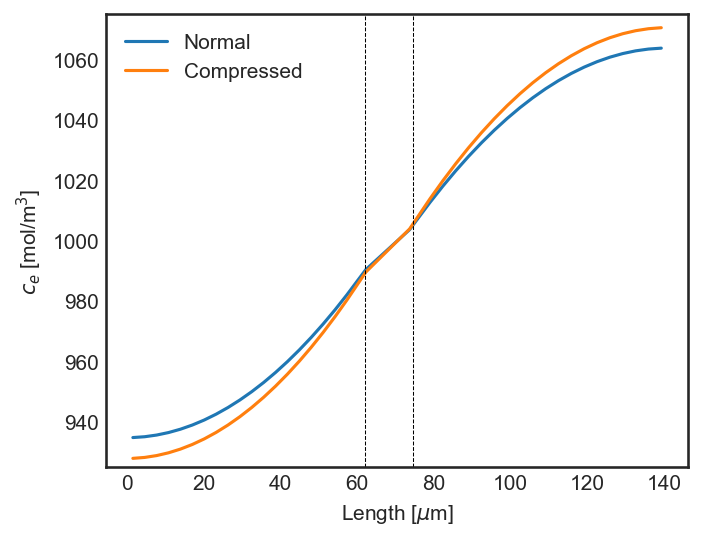

In [87]:
fig = plt.figure(figsize=[5,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(x[:,50]*1e6,c_e_0[:,50])
ax1.plot(x[:,50]*1e6,c_e_1[:,50])
ax1.axvline(x=62,color='k', linestyle='--',linewidth=0.5)
ax1.axvline(x=62+12.5,color='k', linestyle='--',linewidth=0.5)
ax1.set_xlabel('Length [$\mu$m]')
ax1.set_ylim([925,1075])
ax1.set_ylabel('$c_e$ [mol/m$^3$]')
ax1.legend(['Normal', 'Compressed'])
fig.savefig(fig_DIR +'electrolyte_conc.png')